In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load data
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
print(f"Loaded: {filename}")
print(f"Shape: {df.shape}")


Loaded: cleaned_match_winner.csv
Shape: (9380, 23)


In [6]:
# Drop leakage columns
drop_cols = ['match_id', 'FullTimeHomeGoals', 'FullTimeAwayGoals', 'FullTimeResult',
             'result_label', 'HalfTimeHomeGoals', 'HalfTimeAwayGoals', 'HalfTimeResult',
             'HomeTeam', 'AwayTeam', 'Season', 'MatchDate']

features = [col for col in df.columns if col not in drop_cols]
X = df[features].fillna(df[features].median())  # Fill missing values
y = LabelEncoder().fit_transform(df['FullTimeResult'])

print(f"Features: {len(features)}")
print(f"Target classes: {np.unique(df['FullTimeResult'])}")

Features: 14
Target classes: ['A' 'D' 'H']


In [7]:
# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# 4. Define models
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss', verbosity=0)
}

This is kept all together in one cell so that the results are even more clearer sir!!!!


=== BASELINE RESULTS ===
DecisionTree: Accuracy=0.410, F1=0.410
RandomForest: Accuracy=0.507, F1=0.468
XGBoost: Accuracy=0.485, F1=0.464

=== HYPERPARAMETER TUNING ===
DecisionTree: Accuracy=0.522, F1=0.429
RandomForest: Accuracy=0.527, F1=0.435
XGBoost: Accuracy=0.527, F1=0.445

=== SMOTE RESULTS ===
DecisionTree: Accuracy=0.450, F1=0.443
RandomForest: Accuracy=0.484, F1=0.486
XGBoost: Accuracy=0.524, F1=0.522


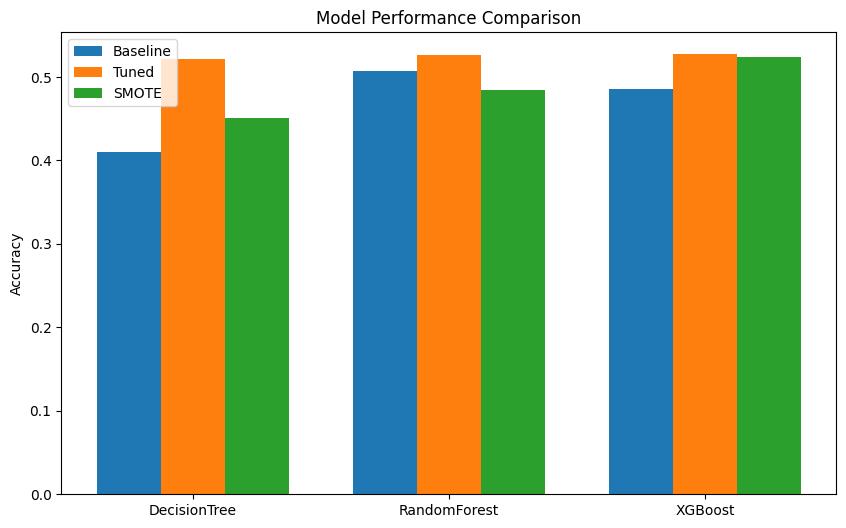


=== BEST MODEL: XGBoost ===
Best Accuracy: 0.524


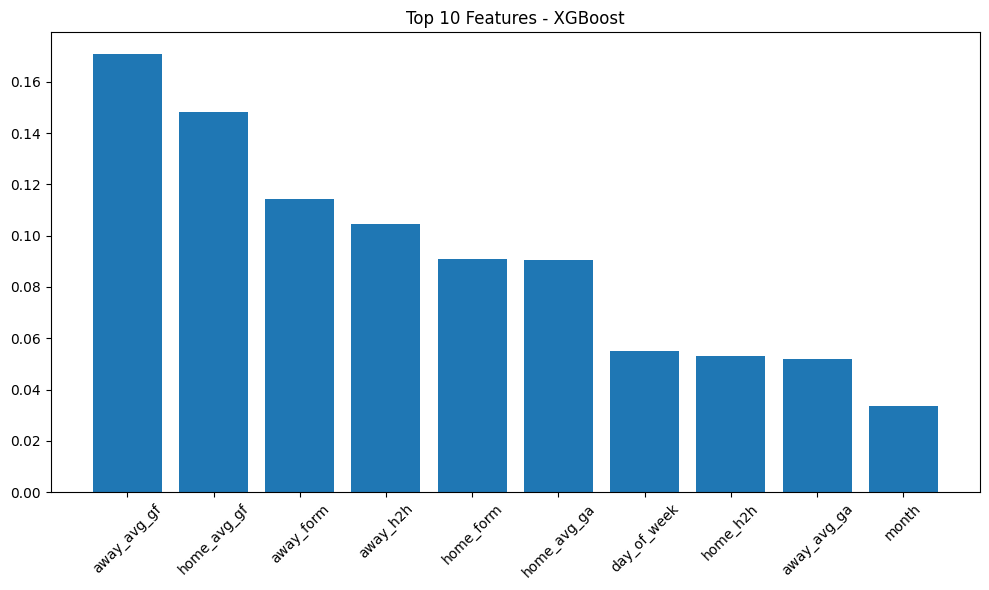


=== SUMMARY TABLE ===
       Model Baseline Tuned SMOTE
DecisionTree    0.410 0.522 0.450
RandomForest    0.507 0.527 0.484
     XGBoost    0.485 0.527 0.524


In [12]:
# 5. Baseline results
print("\n=== BASELINE RESULTS ===")
baseline_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    baseline_results[name] = {'acc': acc, 'f1': f1}
    print(f"{name}: Accuracy={acc:.3f}, F1={f1:.3f}")

# 6. Hyperparameter tuning
print("\n=== HYPERPARAMETER TUNING ===")

# Decision Tree tuning
dt_params = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10]}
dt_best = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5)
dt_best.fit(X_train, y_train)

# Random Forest tuning
rf_params = {'n_estimators': [50, 100], 'max_depth': [5, 10, None]}
rf_best = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5)
rf_best.fit(X_train, y_train)

# XGBoost tuning
xgb_params = {'n_estimators': [50, 100], 'max_depth': [3, 6], 'learning_rate': [0.1, 0.2]}
xgb_best = GridSearchCV(XGBClassifier(random_state=42, eval_metric='mlogloss', verbosity=0),
                        xgb_params, cv=5)
xgb_best.fit(X_train, y_train)

tuned_models = {
    'DecisionTree': dt_best.best_estimator_,
    'RandomForest': rf_best.best_estimator_,
    'XGBoost': xgb_best.best_estimator_
}

# 7. Tuned results
tuned_results = {}
for name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    tuned_results[name] = {'acc': acc, 'f1': f1}
    print(f"{name}: Accuracy={acc:.3f}, F1={f1:.3f}")

# 8. SMOTE (Handle class imbalance)
print("\n=== SMOTE RESULTS ===")
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(
    X_smote, y_smote, test_size=0.2, random_state=42, stratify=y_smote)

smote_results = {}
for name, model in tuned_models.items():
    model.fit(X_train_sm, y_train_sm)
    y_pred = model.predict(X_test_sm)
    acc = accuracy_score(y_test_sm, y_pred)
    f1 = f1_score(y_test_sm, y_pred, average='weighted')
    smote_results[name] = {'acc': acc, 'f1': f1}
    print(f"{name}: Accuracy={acc:.3f}, F1={f1:.3f}")

# 9. Plot comparison
labels = list(models.keys())
baseline_acc = [baseline_results[m]['acc'] for m in labels]
tuned_acc = [tuned_results[m]['acc'] for m in labels]
smote_acc = [smote_results[m]['acc'] for m in labels]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x-width, baseline_acc, width, label='Baseline')
plt.bar(x, tuned_acc, width, label='Tuned')
plt.bar(x+width, smote_acc, width, label='SMOTE')
plt.xticks(x, labels)
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.legend()
plt.show()

# 10. Best model and feature importance
best_model_name = max(smote_results, key=lambda k: smote_results[k]['acc'])
best_model = tuned_models[best_model_name]

print(f"\n=== BEST MODEL: {best_model_name} ===")
print(f"Best Accuracy: {smote_results[best_model_name]['acc']:.3f}")

# Feature importance
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_names = X.columns

    # Plot top 10 features
    indices = np.argsort(importances)[::-1][:10]
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), importances[indices])
    plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45)
    plt.title(f'Top 10 Features - {best_model_name}')
    plt.tight_layout()
    plt.show()

# 11. Summary table
print("\n=== SUMMARY TABLE ===")
summary = pd.DataFrame({
    'Model': labels,
    'Baseline': [f"{baseline_results[m]['acc']:.3f}" for m in labels],
    'Tuned': [f"{tuned_results[m]['acc']:.3f}" for m in labels],
    'SMOTE': [f"{smote_results[m]['acc']:.3f}" for m in labels]
})
print(summary.to_string(index=False))

As far as i saw , the results actualy got a small increase or say slight boost after tuning but won't be sufficient enough 